# Quantum Models

In this notebook we showcase three different quantum models for a Variational Quantum classifier. 

A quantum model defines a quantum circuit and a strategy for classical post-processing of measurements. Currently, three models are available:

- The `"expected_values_model"`, as implemented by the `ExpectedValuesModel` class (see `get_qfunc()` for details on the post-processing strategy).

- The `"probabilities_model"`, as implemented by the `ProbabilitiesModel` class (see `get_qfunc()` for details on the post-processing strategy).

- The `"parity_model"`, as implemented by the `ParityModel` class (see `get_class_from_bit_array()` for details on the post-processing strategy).

The following example demonstrates how the `VariationalClassifier` class can be used for classification based on the [Wine dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-datasetl).

In short, the dataset consists of 
- Number of instances: 178,
- Number of Attributes: 13,
- Number of classes: 3.

We will only use eight features.

In [1]:
import warnings
from typing import Any, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from sklearn.preprocessing import StandardScaler

from tno.quantum.ml.classifiers.vc import VariationalClassifier
from tno.quantum.ml.datasets import get_wine_dataset

warnings.filterwarnings('ignore')

def _std_scale(X_training: NDArray[np.float_], X_validation: NDArray[np.float_]):
    std_scale = StandardScaler().fit(X_training)
    return std_scale.transform(X_training), std_scale.transform(X_validation)

In [2]:
# Load Wine dataset:
X_training, y_training, X_validation, y_validation = get_wine_dataset(
    n_features=8, n_classes=3, random_seed=0
)

# Preprocess data
X_training, X_validation = _std_scale(X_training, X_validation)
X_training = X_training / np.linalg.norm(X_training, ord=2, axis=-1)[:, None]
X_validation = X_validation / np.linalg.norm(X_validation, ord=2, axis=-1)[:, None]

In [3]:
model_name = "probabilities_model"

vc = VariationalClassifier(
    batch_size=10,
    model={
        "name": model_name,
        "options": {"n_layers": 2, "n_trainable_sublayers": 2, "scaling": 0.3},
    },
    optimizer={"name": "adam", "options": {}},
    random_state=0,
    )
vc = vc.fit(X_training, y_training, n_iter = 50)
predictions_validation = vc.predict(X_validation)
predictions_validation

Training iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


array([0., 1., 2., 0., 0., 0., 0., 1., 1., 2., 2., 2., 0., 2., 1., 1., 0.,
       0., 2., 0., 1., 2., 0., 1., 2., 1., 1., 1., 2., 2., 2., 0., 1., 0.,
       2., 0., 2., 2., 1., 2., 0., 0., 1., 1., 1.])

# Post-processing strategies

Let $M=2^m$ be the total number of classes. We define the following three post-processing strategies

- **Probabilities model**: Measure the first $m$ qubits. The decimal representation of the measured qubits represent the class. All other qubits are ignored

- **Expected values model**: The expected value of $M$ qubits are measured. The class is given by the one-hot-encoding of the qubit that is most likely the $1$ state. 

- **Parity model**: 
    [This paper](https://arxiv.org/abs/2212.06663) (by Nico Meyer et al.) presents a way to optimize post-processing step. The authors propose a post-processing function $f(\cdot)$ that assigns an integer (corresponding to a class) to a $n$-bit string $b$ as follows:
    $$
    \begin{align*}
    f(b) = \left[b_0 ... b_{m-2}\left(\bigoplus_{i=m-1}^{n-1} b_i\right) \right]_{10}
    \end{align*}
    $$


The following image shows resulting post processing strategy for different bit strings

![Post-processing strategy example](images/post_processing_strategy_example.png "Post-processing strategy example")

## Accuracy score
An accuracy score can be calculated by comparing classifier predictions with the true labels. This can be done for training dataset and validation dataset for the different post-processing strategies.

![Accuracy Score](images/accuracy_score.png "Accuracy Score")
Accuracy score averaged over 9 different runs.


In [4]:
def _accuracy(labels: NDArray[Any], predictions: NDArray[Any]) -> np.float_:
    return np.sum(np.isclose(labels, predictions)) / labels.size

In [5]:
def calculate_accuracy_for_model(
    model_name: str,
    max_iter: int = 150,
    random_state: int = 0,
) -> Tuple[NDArray[np.float_], NDArray[np.float_]]:
    """
    Create VariationalClassifier and calculate accuracy score for every 5 iterations.

    Args:
        model_name: Name of the model
        max_iter: Total number of iterations
        random_state: Random seed for repeatability

    Returns:
        Accuracy on training and validation dataset
    """
    vc = VariationalClassifier(
        batch_size=10,
        model={
            "name": model_name,
            "options": {"n_layers": 2, "n_trainable_sublayers": 2, "scaling": 0.3},
        },
        optimizer={"name": "adam", "options": {}},
        warm_init=True,
        random_state=random_state,
    )

    # Fit and re-fit by making use of the parameters fitted in the previous iteration
    n_iterations = [5 for _ in range(0, max_iter, 5)]
    acc_validations, acc_trainings = [], []
    for n_iter in n_iterations:
        vc = vc.fit(X_training, y_training, n_iter=n_iter)

        # Predict
        predictions_training = vc.predict(X_training)
        predictions_validation = vc.predict(X_validation)

        # Compute accuracy
        acc_training = _accuracy(y_training, predictions_training)
        acc_validation = _accuracy(y_validation, predictions_validation)

        acc_trainings.append(acc_training)
        acc_validations.append(acc_validation)
    return np.array(acc_trainings), np.array(acc_validations)

In [6]:
def plot_accuracy(
    model_names: List[str],
    acc_trainings: List[NDArray[np.float_]],
    acc_validations: List[NDArray[np.float_]],
) -> None:
    """Plot accuracy score for training dataset and validation dataset

    Args:
        model_name: list of model names
        acc_trainings: list of training dataset accuracy scores
        acc_validations: list of validation dataset accuracy scores
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    for model_name, acc_training, acc_validation in zip(
        model_names, acc_trainings, acc_validations
    ):
        x = list(range(0, 5 * len(acc_training), 5))

        ax1.plot(
            x,
            acc_training,
            label=model_name,
        )

        ax2.plot(
            x,
            acc_validation,
            label=model_name,
        )

    ax1.set_title("Validation dataset")
    ax2.set_title("Training dataset")
    for ax in [ax1, ax2]:
        ax.set_xlabel("Iteration number")
        ax.set_ylabel("Accuracy")
        ax.set_ylim([0, 1])
        ax.legend()

    plt.show()

In [7]:
exp_val_model_train, exp_val_model_validation = calculate_accuracy_for_model(
    "expected_values_model", max_iter=150
)

Training iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.18it/s]


In [8]:
prob_model_train, prob_model_validation = calculate_accuracy_for_model(
    "probabilities_model", max_iter=150
)

Training iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]


In [9]:
parity_model_train, parity_model_validation = calculate_accuracy_for_model(
    "parity_model", max_iter=150
)

Training iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


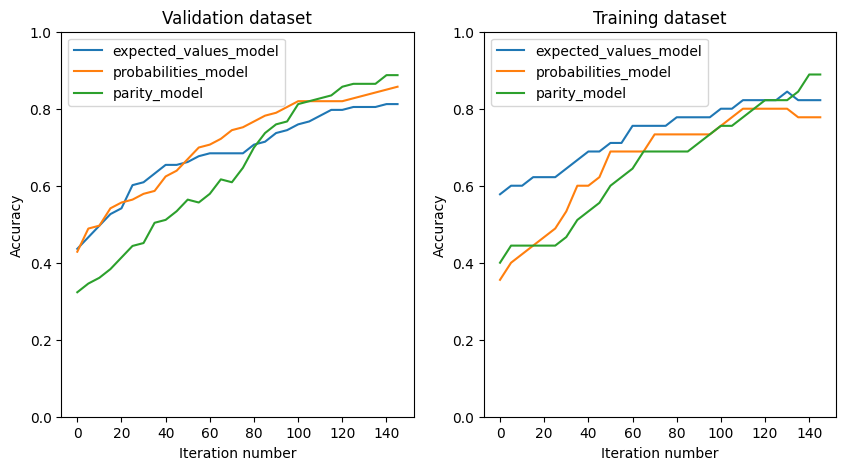

In [10]:
plot_accuracy(
    ["expected_values_model", "probabilities_model", "parity_model"],
    [exp_val_model_train, prob_model_train, parity_model_train],
    [exp_val_model_validation, prob_model_validation, parity_model_validation],
)